# crop tank vids

Edit tank vides to remove sections without a fish. Create new videos, with one video per fish appearance.

In [1]:
from scipy.signal import medfilt
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pathlib import Path
import numpy as np
import pickle
import random
import cv2
import os
%matplotlib notebook

# settings
root_dir = r'Z:\locker\ShareData\tank_for_rick'
bg_frame_num = 500      # frames to include in background calculation
diff_dt = .1            # (seconds) time between background frame computation
diff_range = (4, 20);   # (pixels) difference between frame and background frame for fish detection
buffer = 1.5;           # (s) time before and after fish appearance to keep
med_filtering = 1.0;    # (s) median filter the thresholded signal to remove short periods
bit_rate = 12;          # (megabits per second)


In [13]:
def crop_video(video, max_vids=20, show_pbar=False):
    # todo: rolling background subtraction would be slower but robust to lighting changes..tm.

    # initialize video
    print(f'\n------- ANALYZING {video} -------')
    vid = cv2.VideoCapture(video)
    fps = int(vid.get(cv2.CAP_PROP_FPS))
    frame_delta = round(diff_dt * fps)
    name, ext = os.path.splitext(video)
    
    # get number of frames
    # (this is slow, but robust to errors in video metadata)
    n_frames = 0
    got_frame = True
    while got_frame:
        got_frame, frame = vid.read()
        if got_frame:
            n_frames += 1

    # compute background
    # (median across randomly sampled frames)
    bg_frame_nums = random.sample(range(n_frames), min(n_frames, bg_frame_num))
    bg_frame_nums.sort()
    vid = cv2.VideoCapture(video)  # reinitialize

    bg_frames = []
    for i in bg_frame_nums:
        vid.set(1, i)  # using `set` instead of reading through all the frames is less accurate but much faster
        _, frame = vid.read();
        bg_frames.append(frame)
    vid.release()
    bg = np.median(np.array(bg_frames), axis=0)

    # compute differences between frames and background
    vid = cv2.VideoCapture(video)  # reinitialize
    got_frame = True
    diffs = []
    delta_counter = frame_delta-1  # only compute background every delta frames

    if show_pbar: pbar = tqdm(total=int(n_frames))
    while got_frame:
        got_frame, frame = vid.read();
        delta_counter += 1
        if got_frame and delta_counter==frame_delta:
            diffs.append(np.abs(frame - bg).mean())
            delta_counter = 0
        if show_pbar: pbar.update(1)
    vid.release()
    if show_pbar: pbar.close()
    diffs = np.array(diffs)

    # find fish appearances
    t = np.linspace(0, diffs.shape[0]*(frame_delta/fps), len(diffs))
    threshed = np.logical_and(diffs>diff_range[0], diffs < diff_range[1])
    kernel_sz = round(med_filtering*fps/frame_delta)
    kernel_sz = kernel_sz - kernel_sz%2 + 1  # make odd
    threshed = medfilt(threshed, kernel_sz)  # median filtering to debounce

    # plot
    fig = plt.figure(figsize=(10,2.5))
    ax = plt.axes(xlabel='time (s)', ylabel='frame diffs')
    ax.plot(t, diffs);
    ax.plot(t, threshed*np.ptp(diffs) + min(diffs));
    ax.plot([t[0], t[-1]], np.tile(np.array(diff_range), (2,1)), color='red');  # show thresholds
    
    plt.savefig(os.path.join(os.path.dirname(video), 'cropping.png'), facecolor=(1,1,1,1))
    plt.savefig(os.path.join(root_dir, 'plots', 'cropping', '{}_{}_cropping.png'.format(
        os.path.basename(str(Path(video).parents[1])),
        os.path.basename(str(Path(video).parents[0])) )), facecolor=(1,1,1,1))
    plt.close()
    
    # create vids for each epoch
    if not threshed.any():
        print('fish not detected.')
        return

    start_inds = np.where(np.diff(threshed)==1)[0]+1
    end_inds   = np.where(np.diff(threshed)==-1)[0]+1
    
    start_inds = [0] if len(start_inds)==0 else start_inds
    end_inds = [len(diffs)] if len(end_inds)==0 else end_inds
    if start_inds[0] > end_inds[0]:
        start_inds = np.insert(start_inds, 0, 0)
    if end_inds[-1] < start_inds[-1]:
        end_inds = np.append(end_inds, len(diffs))

    # create new cropped videos
    for i, (start_ind, end_ind) in enumerate(zip(start_inds[:max_vids], end_inds[:max_vids])):
        output_name = '{}_cropped{:03d}{}'.format(name, i, ext)
        start = max(0, start_ind*(frame_delta/fps) - buffer)
        end   = min(n_frames/fps, end_ind*(frame_delta/fps) + buffer)
        print('cropping from {:.1f} to {:.1f} seconds ({:03d})'.format(start, end, i))
        command = 'ffmpeg -i {} -ss {:.2f} -t {:.2f} -vb {}M -y -loglevel panic -stats {}'.format(
            video, start, end-start, bit_rate, output_name)
        os.system(command)

def concat_vids(root_dir, contains=''):
    # concat vids in individual folders (only those containing string 'contains')
    with open(os.path.join(root_dir, 'list.txt'), 'w+') as file:
        vid_folders = [f.path for f in os.scandir(root_dir) if f.is_dir()]
        for vid_folder in vid_folders:
            vid_names = [f.name for f in os.scandir(vid_folder) 
                         if f.path.endswith('.avi') and f.is_file() and contains in f.name]
            file.writelines(['file {}\n'.format(os.path.join(root_dir, vid_folder, v).replace('\\','\\\\')) for v in vid_names])

    # concat with ffmpeg
    command = '{} && cd {} && ffmpeg -y -f concat -safe 0 -i {} -c copy {}'.format(
        root_dir[0] + ':', root_dir, 'list.txt', 'concatenated.avi')
    os.system(command)
    os.remove(os.path.join(root_dir, 'list.txt'))

In [19]:
# loop over and crop all videos

# vid_folders = [f.path for f in os.scandir(os.path.join(root_dir, 'tank_vids')) if f.is_dir()]  # or define manually
vid_folders = [r'Z:\locker\ShareData\tank_for_rick\tank_vids\20200923_Fred',
               r'Z:\locker\ShareData\tank_for_rick\tank_vids\20200923_Greg']
problem_folders = []

for vid_folder in vid_folders:
    sub_folders = [f.path for f in os.scandir(vid_folder) if f.is_dir()]
    for sub_folder in sub_folders:
        try:
            # delete old cropped videos if exist
            old_cropped_vids = [file for file in os.listdir(sub_folder) if 'cropped' in file and file.endswith('.avi')]
            for old_vid in old_cropped_vids:
                os.remove(os.path.join(sub_folder, old_vid))
            
            crop_video(os.path.join(sub_folder, 'videoEOD.avi'))
        except:
            print('PROBLEM ANALYZING {}'.format(os.path.join(sub_folder, 'videoEOD.avi')))
            problem_folders.append((vid_folder, sub_folder))
    
    concat_vids(vid_folder, contains='_cropped')



------- ANALYZING Z:\locker\ShareData\tank_for_rick\tank_vids\20200923_Greg\time_h19m11s54\videoEOD.avi -------
cropping from 24.1 to 28.2 seconds (000)
cropping from 51.9 to 57.0 seconds (001)
cropping from 61.6 to 64.7 seconds (002)
cropping from 63.8 to 68.0 seconds (003)
cropping from 137.3 to 141.9 seconds (004)
cropping from 146.7 to 151.8 seconds (005)
cropping from 157.7 to 162.4 seconds (006)
cropping from 160.9 to 165.4 seconds (007)
cropping from 183.6 to 188.4 seconds (008)
cropping from 201.1 to 205.7 seconds (009)
cropping from 236.3 to 240.3 seconds (010)
cropping from 266.1 to 270.8 seconds (011)

------- ANALYZING Z:\locker\ShareData\tank_for_rick\tank_vids\20200923_Greg\time_h19m18s1\videoEOD.avi -------
cropping from 14.5 to 19.0 seconds (000)
cropping from 17.0 to 20.9 seconds (001)

------- ANALYZING Z:\locker\ShareData\tank_for_rick\tank_vids\20200923_Greg\time_h19m4s10\videoEOD.avi -------
cropping from 43.1 to 47.0 seconds (000)
cropping from 81.6 to 85.8 secon

# try filtering audio

In [10]:
from scipy.io import wavfile
from scipy import signal

# settings
video = r'Z:\locker\ShareData\tank_for_rick\tank_vids\20200923_Greg\concatenated.avi'
thresh_factor = 6
eod_lims = [-.4, .4]  # (ms)
hpf = 200


# create audio-only file
name, ext = os.path.splitext(video)
audio_file = name + '_audio.wav'
command = f'ffmpeg -i {video} -vn -y -acodec pcm_s32le {audio_file}'
os.system(command)

# read file
fs, data = wavfile.read(audio_file)
data = data[:,0]

<IPython.core.display.Javascript object>


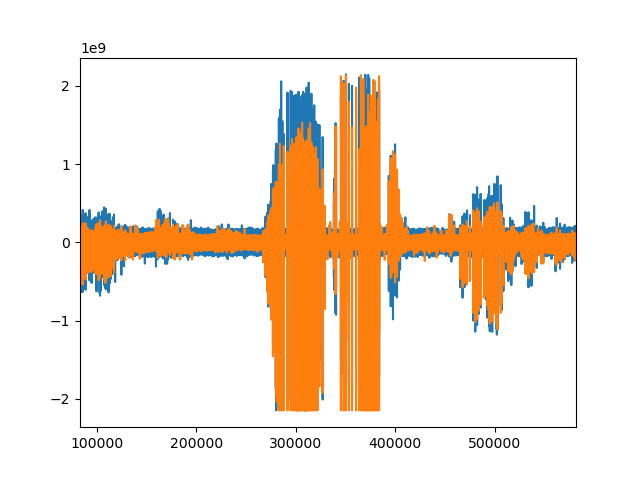

In [11]:
# high-pass
sos = signal.butter(10, hpf, 'hp', fs=fs, output='sos')
filtered = signal.sosfilt(sos, data)

# low-pass (convolve with average eod shape)
thresh = thresh_factor * data.std()
eod_times = np.where(np.diff((data>thresh).astype('int'))==1)[0]+1
inds = np.arange(eod_lims[0]/1000*fs, eod_lims[1]/1000*fs).astype('int')
inds = inds + eod_times[:,None]

eods = []
for i in range(inds.shape[0]):
    eods.append(data[inds[i]])
eods = np.array(eods)

template = np.median(eods, 0)
template = template / sum(template)

filtered = signal.correlate(filtered, template, 'same')

filtered = filtered.astype('int32')

ax = plt.axes(xlim=(eod_times[1], eod_times[100]+48000*2))
ax.plot(data);
ax.plot(filtered);
plt.show()

In [12]:
# write filtered audio to disk
audio_file_filt = name + '_audio_filtered.wav'
wavfile.write(audio_file_filt, fs, filtered)

In [ ]:





































`